In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
 # Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Model Initialization

In [ ]:
models = ["neulab/codebert-java", "microsoft/codebert-base", "google-bert/bert-base-cased"]
src = models[0]
tokenizer = AutoTokenizer.from_pretrained(src)
model = AutoModel.from_pretrained(src)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at neulab/codebert-java and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Data Fetching

In [ ]:
def importJSON(filename):
  with open(filename, "r") as file:
    dataset = json.load(file)
  return dataset

# Bug Clustering

In [ ]:
def mean_pooling(output, attention_mask):
  mask_expanded = attention_mask.unsqueeze(-1).expand(output.size()).float()
  embed_sum = torch.sum(output * mask_expanded, 1)
  mask_sum = torch.clamp(mask_expanded.sum(1), min=1e9)
  return embed_sum/mask_sum

## Defects4J Experiment

In [ ]:
def embed_code(tokenizer, model, code, max_len=512):
  encoding = tokenizer.batch_encode_plus(
    code,
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
    add_special_tokens=True
  )
  input_ids = encoding["input_ids"]
  attention_masks = encoding["attention_mask"]
  with torch.no_grad():
    output = model(input_ids, attention_masks)
  return (output[0], attention_masks)

In [ ]:
def embed_all_codes(dataset, tokenizer, model, n_batch = 10):
  embed = torch.zeros((len(dataset), 512, 768))
  mask = torch.zeros((len(dataset), 512))
  i = 0
  for data in dataset:
    codes = ["".join(data["method"])]
    (embed[i, :, :], mask[i]) = embed_code(tokenizer, model, codes)
    i += 1
    if i % 10 == 1:
      print(f"Dataset {i} is extracted")
  return (embed, mask)

In [ ]:
dataset = importJSON("defects4jFL.json")
print(dataset)

[{'pid': 'Chart', 'bid': 1, 'method_path': './dataset/Chart/1/AbstractCategoryItemRenderer.java', 'method': ['public LegendItemCollection getLegendItems() {\n', 'LegendItemCollection result = new LegendItemCollection();\n', 'if (this.plot == null) {\n', 'return result;\n', '}\n', 'int index = this.plot.getIndexOf(this);\n', 'CategoryDataset dataset = this.plot.getDataset(index);\n', 'if (dataset != null) {\n', 'return result;\n', '}\n', 'int seriesCount = dataset.getRowCount();\n', 'if (plot.getRowRenderingOrder().equals(SortOrder.ASCENDING)) {\n', 'for (int i = 0; i < seriesCount; i++) {\n', 'if (isSeriesVisibleInLegend(i)) {\n', 'LegendItem item = getLegendItem(index, i);\n', 'if (item != null) {\n', 'result.add(item);\n', '}\n', '}\n', '}\n', '}\n', 'else {\n', 'for (int i = seriesCount - 1; i >= 0; i--) {\n', 'if (isSeriesVisibleInLegend(i)) {\n', 'LegendItem item = getLegendItem(index, i);\n', 'if (item != null) {\n', 'result.add(item);\n', '}\n', '}\n', '}\n', '}\n', 'return resu

In [ ]:
embeddings, masks = embed_all_codes(dataset, tokenizer, model)
np.save("embeddings_d4j.npy", embeddings)
np.save("masks_d4j.npy", masks)

embeddings = np.load("embeddings_d4j.npy")
masks = np.load("masks_d4j.npy")

Dataset 1 is extracted
Dataset 11 is extracted
Dataset 21 is extracted
Dataset 31 is extracted
Dataset 41 is extracted
Dataset 51 is extracted
Dataset 61 is extracted
Dataset 71 is extracted
Dataset 81 is extracted
Dataset 91 is extracted
Dataset 101 is extracted
Dataset 111 is extracted
Dataset 121 is extracted
Dataset 131 is extracted
Dataset 141 is extracted
Dataset 151 is extracted
Dataset 161 is extracted
Dataset 171 is extracted
Dataset 181 is extracted
Dataset 191 is extracted
Dataset 201 is extracted
Dataset 211 is extracted
Dataset 221 is extracted
Dataset 231 is extracted
Dataset 241 is extracted
Dataset 251 is extracted
Dataset 261 is extracted
Dataset 271 is extracted
Dataset 281 is extracted
Dataset 291 is extracted
Dataset 301 is extracted
Dataset 311 is extracted
Dataset 321 is extracted
Dataset 331 is extracted
Dataset 341 is extracted
Dataset 351 is extracted
Dataset 361 is extracted
Dataset 371 is extracted
Dataset 381 is extracted
Dataset 391 is extracted
Dataset 401

In [ ]:
embeddings = torch.from_numpy(embeddings)
masks = torch.from_numpy(masks)
mean = mean_pooling(embeddings, masks)

In [ ]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit_transform(mean)

labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def plotClusters(features, labels):
  pca = PCA(n_components = 2)
  reduced_features = pca.fit_transform(features)
  scatter_x = reduced_features[:, 0]
  scatter_y = reduced_features[:, 1]

  cdict = {
  1: '#440154',
  2: '#482878',
  3: '#3e4989',
  4: '#31688e',
  5: '#26828e',
  6: '#1f9e89',
  7: '#35b779',
  8: '#6ece58',
  9: '#b5de2b',
  10: '#fde725'
}
  fig, ax = plt.subplots()
  for g in np.unique(labels):
      ix = np.where(labels == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g + 1], label = g, s = 100)
  ax.legend(loc = 'lower left', mode = "expand", ncol = 10)
  plt.show()

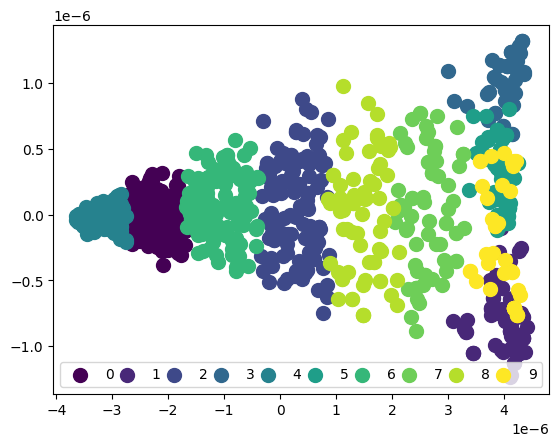

In [ ]:
plotClusters(mean, labels)

In [ ]:
for i in range(len(dataset)):
  dataset[i]["cluster"] = int(labels[i])

In [ ]:
with open("clustered_defects4j.json", "w") as file:
  json.dump(dataset, file)

## DebugBench Experiment

In [ ]:
BUG_TYPES = ['condition error', 'faulty indexing', 'illegal comment', 'illegal keywords', 'illegal separation', 'missing colons', 'misused == or =', 'operation error', 'other error', 'unclosed parentheses', 'unclosed string', 'undefined methods', 'undefined objects', 'variable error', 'illegal indentation']
LANGS = ["cpp", "java", "python3"]
def extract_dbench(filename):
  with open(filename, "r") as file:
    dataset = json.load(file)

  for i in range(len(dataset)):
    dataset[i]["bug_type"] = BUG_TYPES.index(dataset[i]["bug_type"])
    dataset[i]["buggy_code"] = dataset[i]["buggy_code" ].split("\n")
  return dataset

In [ ]:
lang_map = {
    "python3": 0,
    "java": 1,
    "cpp": 2
}

dbench_dataset = extract_dbench("dbench.json")
true_label = [data["bug_type"] for data in dbench_dataset]
true_label_lang = [lang_map[data["lang"]] for data in dbench_dataset]

In [ ]:
def embed_all_codes_db(dataset, tokenizer, model, n_batch = 10):
  embed = torch.zeros((len(dataset), 128, 768))
  mask = torch.zeros((len(dataset), 128))
  i = 0
  for data in dataset:
    codes = ["".join(data["buggy_code"])]
    (embed[i, :, :], mask[i]) = embed_code(tokenizer, model, codes, max_len=128)
    i += 1
    if i % 10 == 1:
      print(f"Dataset {i} is extracted")
  return (embed, mask)

In [ ]:
# (embed_db, mask_db) = embed_all_codes_db(dbench_dataset, tokenizer, model)
# np.save("embeddings_db.npy", embed_db)
# np.save("masks_db.npy", mask_db)

embed_db = np.load("embeddings_db.npy")
mask_db = np.load("masks_db.npy")

In [ ]:
embed_db = torch.from_numpy(embed_db)
mask_db = torch.from_numpy(mask_db)
mean = mean_pooling(embed_db, mask_db)

In [ ]:
kmeans_bugs = KMeans(n_clusters = 15)
kmeans_bugs.fit_transform(mean)

label_bugs = kmeans_bugs.labels_

kmeans_langs = KMeans(n_clusters = 3)
kmeans_langs.fit_transform(mean)

label_langs = kmeans_langs.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def plotClusters(features, labels):
  pca = PCA(n_components = 2)
  reduced_features = pca.fit_transform(features)
  scatter_x = reduced_features[:, 0]
  scatter_y = reduced_features[:, 1]

  cdict = {
  1: '#ddce84',
  2: '#c9dd83',
  3: '#a8df85',
  4: '#86e087',
  5: '#85dfa9',
  6: '#84ded3',
  7: '#86c8e0',
  8: '#86a4e0',
  9: '#8e89e2',
  10: '#b087e1',
  11: '#d387e0',
  12: '#df85c9',
  13: '#e086a6',
  14: '#e18b88',
  15: '#e0ad86'
}
  fig, ax = plt.subplots()
  for g in np.unique(labels):
      ix = np.where(labels == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g + 1], label = g, s = 100)
  ax.legend(loc = 'lower left', mode = "expand", ncol = 10)
  plt.show()

In [ ]:
def plotClustersLangs(features, labels, true_labels):
  pca = PCA(n_components = 2)
  reduced_features = pca.fit_transform(features)
  scatter_x = reduced_features[:, 0]
  scatter_y = reduced_features[:, 1]

  cdict = {
    0: '#86c8e0',
    1: '#85dfa9',
    2: '#df85c9',
  }

  mdict = {
      0: "+",
      1: "1",
      2: "x"
  }
  fig, ax = plt.subplots()

  for label in np.unique(labels):
    for true_label in np.unique(true_labels):

        # Select points based on labels and true_labels
        ix = np.where((labels == label) & (true_labels == true_label))

        ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[label], marker=mdict[true_label], label = label, s = 25)

  ax.legend(loc = 'lower left', mode = "expand", ncol = 10)
  plt.show()

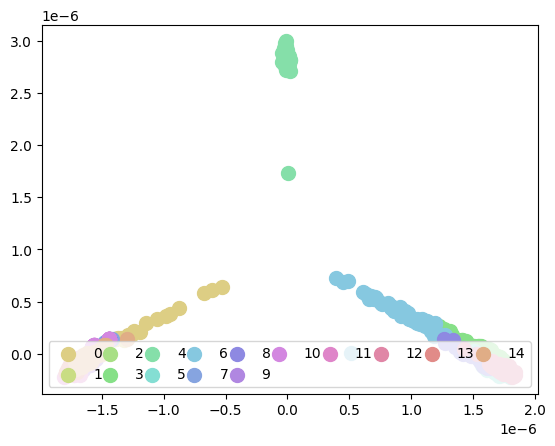

In [ ]:
plotClusters(mean, label_bugs)

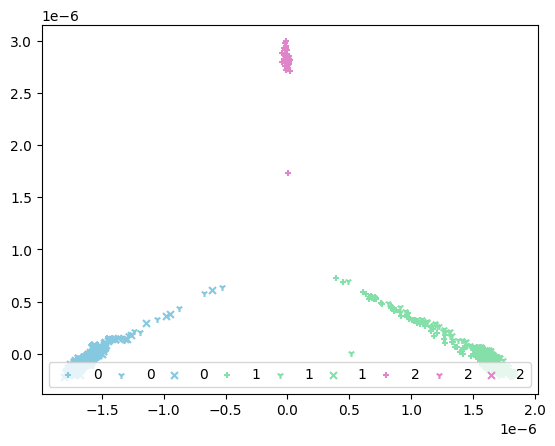

In [ ]:
plotClustersLangs(mean, label_langs, true_label_lang)

# Evaluation DebugBench Clustering: C = 3 vs C = 15
Language-based vs bug-based clustering

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import rand_score

In [ ]:
print(f"Evaluation for Language Clustering: ")
print(f"NMI: {NMI(label_langs, true_label_lang)}")
print(f"Rand Index: {rand_score(label_langs, true_label_lang)}")

Evaluation for Language Clustering: 
NMI: 0.5140268386208403
Rand Index: 0.7267286594720223


In [ ]:
print(f"Evaluation for Bugs Clustering: ")
print(f"NMI: {NMI(label_bugs, true_label)}")
print(f"Rand Index: {rand_score(label_bugs, true_label)}")

Evaluation for Bugs Clustering: 
NMI: 0.10949452303256721
Rand Index: 0.8470178948055054


# Language Specific Bug Clustering
Can we cluster the bug after we isolate the data to be in the same language?

In [ ]:
index_py = []
index_cpp = []
index_java = []

for i in range(len(dbench_dataset)):
  if dbench_dataset[i]["lang"] == "python3":
    index_py.append(i)
  elif dbench_dataset[i]["lang"] == "java":
    index_java.append(i)
  else:
    index_cpp.append(i)

true_label_py = [dbench_dataset[i]["bug_type"] for i in index_py]
true_label_java = [dbench_dataset[i]["bug_type"] for i in index_java]
true_label_cpp = [dbench_dataset[i]["bug_type"] for i in index_cpp]

## Python Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


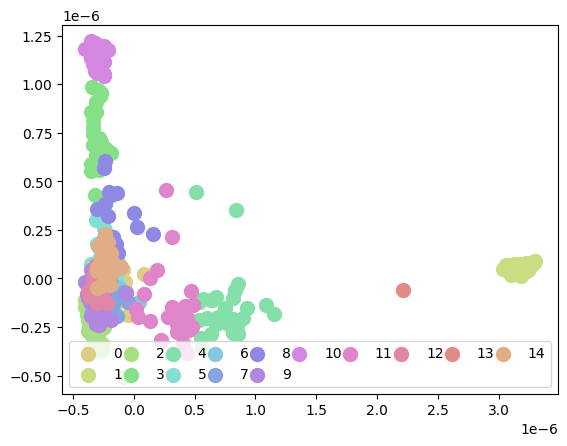

In [ ]:
features_py = mean[index_py]
kmeans_bugs_py = KMeans(n_clusters = 15)
kmeans_bugs_py.fit_transform(features_py)

label_bugs_py = kmeans_bugs_py.labels_
plotClusters(features_py, label_bugs_py)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


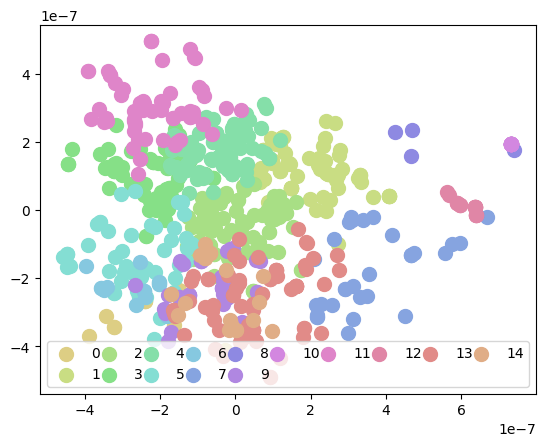

In [ ]:
features_cpp = mean[index_cpp]
kmeans_bugs_cpp = KMeans(n_clusters = 15)
kmeans_bugs_cpp.fit_transform(features_cpp)

label_bugs_cpp = kmeans_bugs_cpp.labels_
plotClusters(features_cpp, label_bugs_cpp)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


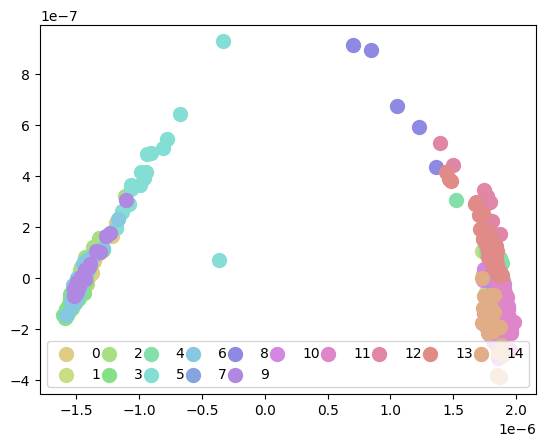

In [ ]:
features_java = mean[index_java]
kmeans_bugs_java = KMeans(n_clusters = 15)
kmeans_bugs_java.fit_transform(features_java)

label_bugs_java = kmeans_bugs_java.labels_
plotClusters(features_java, label_bugs_java)

In [ ]:
print(f"Evaluation for Python Bugs Clustering: ")
print(f"NMI: {NMI(label_bugs_py, true_label_py)}")
print(f"Rand Index: {rand_score(label_bugs_py, true_label_py)}")
print()
print(f"Evaluation for Java Bugs Clustering: ")
print(f"NMI: {NMI(label_bugs_java, true_label_java)}")
print(f"Rand Index: {rand_score(label_bugs_java, true_label_java)}")
print()
print(f"Evaluation for CPP Bugs Clustering: ")
print(f"NMI: {NMI(label_bugs_cpp, true_label_cpp)}")
print(f"Rand Index: {rand_score(label_bugs_cpp, true_label_cpp)}")

Evaluation for Python Bugs Clustering: 
NMI: 0.12097250093205447
Rand Index: 0.8448238107710077

Evaluation for Java Bugs Clustering: 
NMI: 0.28993678900725445
Rand Index: 0.8450762141084722

Evaluation for CPP Bugs Clustering: 
NMI: 0.04924099896870796
Rand Index: 0.8409292846953332
